## Prerequisite Packages

In [1]:
# Based on https://www.tensorflow.org/datasets/keras_example
# use pip install <package> to find any packages that are missing
from tensorflow import keras         # for fitting DNNs
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

## We split the data into training and testing

In [2]:
(ds_train,ds_val, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train[:80%]','train[80%:]','test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


## Functions: normalizing images, and returning labels/images

In [3]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label
def get_label(image,label):
    return label
def get_image(image,label):
    return image


## We apply these functions to extract model-ready data

In [4]:
# this just normalizes the image
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# cache and prefetch save memory 
ds_train = ds_train.cache()
# we shuffle data (reduces effects of order when training model)
ds_train = ds_train.shuffle(ds_info.splits['train[:80%]'].num_examples)
# batch size tells us how many samples are needed for stochastic gradient descent 
# (a small number like 32 is empirically found to be better)
ds_train = ds_train.batch(32)# batch of 32
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)


ds_val = ds_val.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.cache()
ds_val = ds_val.shuffle(ds_info.splits['train[80%:]'].num_examples)
ds_val = ds_val.batch(32)# batch of 32
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)


ds_test_label=ds_test.map(
    get_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test_images=ds_test.map(
    get_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)


## Model training

In [5]:

# this example model 
#    - first flattens data into a vector (image is 28 x 28)
#    - then creates a dense 128-node layer
#    - then creates a dropout "layer" (it says how many nodes are dropped out in previous layer)
#    - then another 128-node layer
#    - and finally 10-node layer as the head. 
# The max value of the head = the predicted image
#
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128,activation='relu'),
tf.keras.layers.Dropout(.2, input_shape=(128,)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10)
])

# this specifies how we find the best NN
# - Optimizer like Adam is found to work well
# - Loss is "sparse categorical cross entropy" (you can choose whatever loss function on keras improves your model)
# - We also record accuracy ("metric"), this does not affect training
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
# this is stuff we record
# "early stopping" tells us when we found the optimum without training more epochs
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=8),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

# the training of the model
# we use ds_train data, and up to 30 epochs (less when Early Stopping is used)
# we also record callbacks, and we determine the optimal model by where validation is smallest
history=model.fit(
    ds_train,
    epochs=30,
    callbacks=my_callbacks,
    validation_data=ds_val
)


Epoch 1/30
1500/1500 [==============================] - 5s 2ms/step - loss: 0.5052 - sparse_categorical_accuracy: 0.8496 - val_loss: 0.1465 - val_sparse_categorical_accuracy: 0.9562
Epoch 2/30
1500/1500 [==============================] - 2s 2ms/step - loss: 0.1476 - sparse_categorical_accuracy: 0.9552 - val_loss: 0.1161 - val_sparse_categorical_accuracy: 0.9660
Epoch 3/30
1500/1500 [==============================] - 2s 2ms/step - loss: 0.1069 - sparse_categorical_accuracy: 0.9662 - val_loss: 0.1014 - val_sparse_categorical_accuracy: 0.9697
Epoch 4/30
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0910 - sparse_categorical_accuracy: 0.9696 - val_loss: 0.1008 - val_sparse_categorical_accuracy: 0.9704
Epoch 5/30
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0738 - sparse_categorical_accuracy: 0.9751 - val_loss: 0.0866 - val_sparse_categorical_accuracy: 0.9755
Epoch 6/30
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0677 - spars

## Here we check the accuracy in the held-out test dataset

In [6]:

gt_labels=list(ds_test_label)
predictions=[np.argmax(im) for im in model.predict(ds_test)]
accuracy_score(predictions,gt_labels)

0.9783

## How does loss in training/validation vary with epoch?

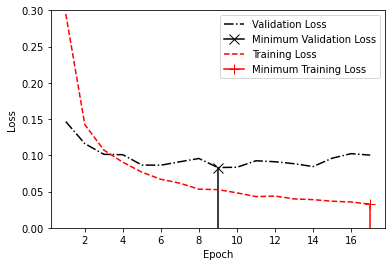

In [7]:
# These definitions make the plot code easier to read
minvalx=np.argmin(history.history['val_loss'])+1
minvaly=min(history.history['val_loss'])
mintrainx=np.argmin(history.history['loss'])+1
mintrainy=min(history.history['loss'])
lowpoint_val=np.array([[minvalx,-10],[minvalx,minvaly]])
lowpoint_train=np.array([[mintrainx,-10],[mintrainx,mintrainy]])

# N.B., it's always good to label axes and lines
plt.plot(list(range(1,len(history.history['val_loss'])+1)),history.history['val_loss'],'k-.',label='Validation Loss')
plt.plot(lowpoint_val[:,0],lowpoint_val[:,1],'kx-',markersize=10,label='Minimum Validation Loss')
plt.plot(list(range(1,len(history.history['loss'])+1)),history.history['loss'],'r--',label='Training Loss')
plt.plot(lowpoint_train[:,0],lowpoint_train[:,1],'r+-',markersize=10,label='Minimum Training Loss')
# creates legend from "label" attribute
plt.legend()
# y limit
plt.ylim([0,0.3])
# axes labels
plt.ylabel('Loss')
plt.xlabel('Epoch')
# show the plot
# to save figure, you can use plt.savefig(<file name>)
plt.show()


## Accuracy is only a number. Let's look at examples

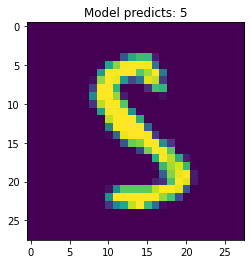

In [8]:
random_int=np.random.randint(0,len(ds_test_images))
image=(np.array(list(ds_test_images)[random_int])/256)[:,:,0]
plt.imshow(image)
plt.title('Model predicts: '+str(predictions[random_int]))
plt.show()


In [9]:
confidence = model.predict(ds_test)
conlst = confidence.tolist()
print(conlst)

[[-9.541086196899414, -5.026315689086914, 20.29583740234375, 0.4714980125427246, 1.9141676425933838, -7.418595790863037, -6.14481258392334, -5.357321739196777, -8.166022300720215, -11.692543983459473], [21.804428100585938, -28.555585861206055, -7.218822002410889, -17.512901306152344, -18.339916229248047, -6.279516220092773, 1.2679297924041748, -9.92548942565918, -16.35902976989746, -8.54967212677002], [-15.281152725219727, -13.193038940429688, -10.618240356445312, -11.024114608764648, 22.54936981201172, -7.52645206451416, -16.945831298828125, 1.9243932962417603, -8.989154815673828, 5.226060390472412], [-8.087571144104004, -1.6244713068008423, -4.290036678314209, -4.870731353759766, -9.366292953491211, -0.30750393867492676, -6.442936897277832, -6.3080010414123535, 9.987696647644043, -7.10291862487793], [-14.825506210327148, -9.647241592407227, -2.374289035797119, -1.0163366794586182, -2.558856248855591, -6.564119815826416, -25.36692237854004, 24.033689498901367, -10.679950714111328, -3.

In [10]:
from sklearn.manifold import TSNE

In [11]:
con_embedded = TSNE(n_components=2).fit_transform(confidence)

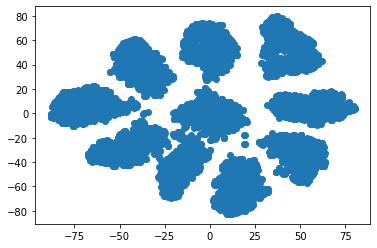

In [12]:
x = [x for x,y in con_embedded]
y = [y for x,y in con_embedded]
plt.scatter(x,y)

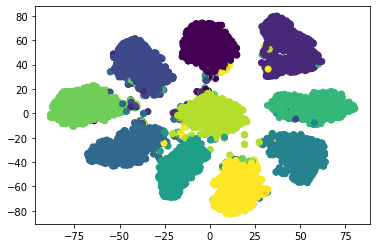

In [44]:
plt.scatter(x, y, c=gt_labels)
plt.show()

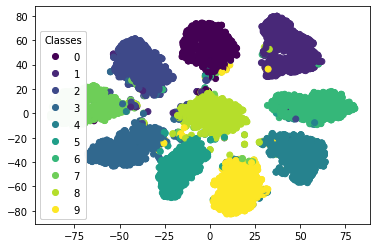

In [46]:
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=gt_labels)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

In [15]:
numlabels = []
for i in range(len(gt_labels)):
    lclass = str(gt_labels[i]).split()[0][-2]
    numlabels.append(lclass)
# numlabels

In [14]:
errors = []
count = 0
for i in range(len(predictions)):
    if str(predictions[i]) != str(gt_labels[i]).split()[0][-2]:
        errors.append(i)

errors[:10]

[30, 61, 98, 152, 221, 345, 372, 435, 510, 588]

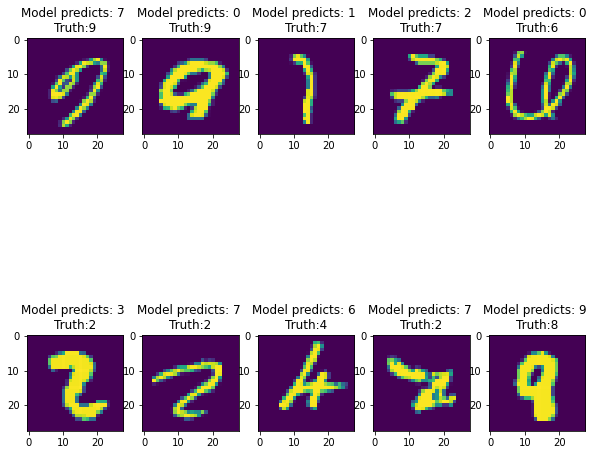

In [15]:
columns = 5
rows = 2
fig = plt.figure(figsize=(10,10))
for i in range(columns*rows):
    image = (np.array(list(ds_test_images)[errors[i]])/256)[:,:,0]
    fig.add_subplot(rows,columns,i+1)
    plt.imshow(image)
    plt.title('Model predicts: '+str(predictions[errors[i]])+' \n'+'Truth:'+str(gt_labels[errors[i]]).split()[0][-2])
plt.show()

In [16]:
errors_conf = []
for i in errors:
    errors_conf.append(list(confidence[i]))
errors_conf = np.array(errors_conf)

In [17]:
err_embedded = TSNE(n_components=2).fit_transform(errors_conf)

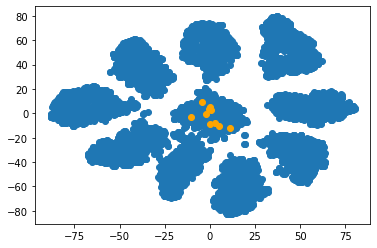

In [50]:
x = [x for x,y in con_embedded]
y = [y for x,y in con_embedded]
plt.scatter(x,y)
x1 = [x1 for x1,y1 in err_embedded[:10]]
y1 = [y1 for x1,y1 in err_embedded[:10]]
plt.scatter(x1,y1,c='orange')
plt.show()